<a href="https://colab.research.google.com/github/francescapoli98/pattern-recognition-systems/blob/main/m3_assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intelligent Systems for Pattern Recognition: midterm 3**
#### Francesca Poli [560190]


---


## Fake News Classification


 **Assignment 5:**
The [dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset) contains real and fake news, including their *title, text, subject, and date.*

The objective is to **train a binary classifier to recognize fake news**. You are free to choose the model's architecture, but you should describe and justify your design choices.

Notice that the fake and real news in the dataset are balanced. However, in the real world, real news are much more frequent than fake ones (hopefully).

Simulate the effect of the data imbalance by undersampling/oversampling one of the classes in the training set and compute the test accuracy on a (balanced) test set.

Then, try to use a mechanism to make the training robust to imbalances, such as weighting the loss for the samples depending on their class. Discuss the results of this mitigation.

NOTE ON *PREPROCESSING*: you are allowed to preprocess the data however you want (e.g. using pretrained embeddings, dropping some features, just a bag-of-words), but the classification model must be trained by yourself.

# Binary Classifier

## Work setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#some useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#no warnings to distract us (checked before inserting the ignore filter)
import warnings
warnings.filterwarnings("ignore")

#### Loading of the dataset and work setup

In [ ]:
fake_news = pd.read_csv('/content/drive/MyDrive/ISPR/midterm 3 FAKE NEWS DET/archive/Fake.csv', header=None)
true_news = pd.read_csv('/content/drive/MyDrive/ISPR/midterm 3 FAKE NEWS DET/archive/True.csv', header=None)

In [ ]:
headers = fake_news.iloc[0]
fake_news  = pd.DataFrame(fake_news.values[1:], columns=headers)

In [ ]:
headers = true_news.iloc[0]
true_news  = pd.DataFrame(true_news.values[1:], columns=headers)

In [ ]:
del fake_news['date']
del true_news['date']

In [ ]:
fake_news.info()
true_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
dtypes: object(3)
memory usage: 550.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
dtypes: object(3)
memory usage: 502.1+ KB


In [ ]:
fake_news

,title,text,subject
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News
...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east


In [ ]:
true_news

,title,text,subject
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews
...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews


## Data preprocessing

Here are randomly selected a specified fraction of the total number of rows through the *pandas* method `sample()`.
Let’s set `frac=0.80` for the fake news in order to get a random selection of the total rows from the dataframe, according to the assessment that:

*the fake and real news in the dataset are balanced. However, in the real world, real news are much more frequent than fake ones (hopefully)*

In [ ]:
#true_samples = true_news.sample(frac=0.65)
true_news['label'] = 0
fake_news['label'] = 1
true_news

,title,text,subject,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,0
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,0
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,0
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,0


In [ ]:
fake_samples = fake_news.sample(frac=0.60)
fake_samples

,title,text,subject,label
15137,Colin Powell Jokes About Why He’s Still A Repu...,Colin Powell believes he s fooled us all into ...,politics,1
18340,DONALD TRUMP JR. Releases Emails Related To Ru...,Donald Trump Jr. took to Twitter today to rele...,left-news,1
13891,WATCH: FORMER TRUMP GIRLFRIEND Sets The Record...,It s interesting how much vitriol some women h...,politics,1
21972,Reflections on a World Gone Mad and Pushing Ba...,Andre Vltchek Anti DiplomaticoThe following i...,US_News,1
8976,Tennessee GOP Lawmaker Offers To Fund Bundy T...,Most Republican lawmakers have remained silent...,News,1
...,...,...,...,...
16212,A MUST WATCH! JUDGE NAPOLITANO: “For the first...,,Government News,1
21008,MUSLIMS CRITICIZE New State Law That Permanent...,Maybe it s time for Muslim citizens and immigr...,left-news,1
1711,Trump State Campaign Chair In Hot Water For T...,"Donald Trump is himself, a pervert. We all kne...",News,1
16531,JUDGE JEANINE PIRRO: “We’re tired of being lec...,Next stop after BREXIT is the US! Judge Jeanin...,Government News,1


In [ ]:
news_df = pd.concat([fake_samples, true_news], axis=0)
news_df

,title,text,subject,label
15137,Colin Powell Jokes About Why He’s Still A Repu...,Colin Powell believes he s fooled us all into ...,politics,1
18340,DONALD TRUMP JR. Releases Emails Related To Ru...,Donald Trump Jr. took to Twitter today to rele...,left-news,1
13891,WATCH: FORMER TRUMP GIRLFRIEND Sets The Record...,It s interesting how much vitriol some women h...,politics,1
21972,Reflections on a World Gone Mad and Pushing Ba...,Andre Vltchek Anti DiplomaticoThe following i...,US_News,1
8976,Tennessee GOP Lawmaker Offers To Fund Bundy T...,Most Republican lawmakers have remained silent...,News,1
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,0
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,0
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,0
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,0


Now we can create a single column containing all the useful text that we will process and feed to our binary classifier.

In [ ]:
news_df["whole_text"] = news_df["title"] + news_df["text"]
news_df

,title,text,subject,label,whole_text
15137,Colin Powell Jokes About Why He’s Still A Repu...,Colin Powell believes he s fooled us all into ...,politics,1,Colin Powell Jokes About Why He’s Still A Repu...
18340,DONALD TRUMP JR. Releases Emails Related To Ru...,Donald Trump Jr. took to Twitter today to rele...,left-news,1,DONALD TRUMP JR. Releases Emails Related To Ru...
13891,WATCH: FORMER TRUMP GIRLFRIEND Sets The Record...,It s interesting how much vitriol some women h...,politics,1,WATCH: FORMER TRUMP GIRLFRIEND Sets The Record...
21972,Reflections on a World Gone Mad and Pushing Ba...,Andre Vltchek Anti DiplomaticoThe following i...,US_News,1,Reflections on a World Gone Mad and Pushing Ba...
8976,Tennessee GOP Lawmaker Offers To Fund Bundy T...,Most Republican lawmakers have remained silent...,News,1,Tennessee GOP Lawmaker Offers To Fund Bundy T...
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,0,'Fully committed' NATO backs new U.S. approach...
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,0,LexisNexis withdrew two products from Chinese ...
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,0,Minsk cultural hub becomes haven from authorit...
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,0,Vatican upbeat on possibility of Pope Francis ...


Let's also take a quick look at the fake and true data distribution, as to keep an eye on the statistics.

In [ ]:
neg, pos = np.bincount(news_df['label'])
total = neg + pos
print('Examples:\n    Total: {}\n    Fake mews: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 35506
    Fake mews: 14089 (39.68% of total)



1: Unreliable
0: Reliable
Distribution of labels:
0    21417
1    14089
Name: label, dtype: int64


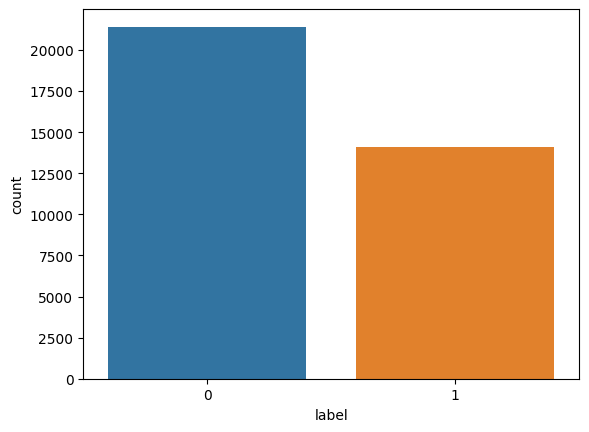

In [ ]:
sns.countplot(x="label", data=news_df);
print("1: Unreliable")
print("0: Reliable")
print("Distribution of labels:")
print(news_df.label.value_counts());

###Data preprocessing
During this phase, the text at our disposal will be processed through the following methods:
- some data cleaning in order to get rid of errors and detrimental elememts, and to lower all capital letters which are not needed for this task
- stop words from the `nltk` library will be dropped
- tokenization and lemmatization also through `nltk` methods

In [ ]:
import re

#nltk lib
import nltk
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
stop_words = stopwords.words('english')

def clean_text(text):
 #output = ''
 text = str(text).replace(r'http[\w:/\.]+','') # removing urls
 text = str(text).replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
 text = str(text).replace(r'\.\.+','.') #replace multiple periods with a single one
 text = str(text).replace(r'\.','.') #replace periods with a single one
 text = str(text).replace(r'\s\s+',' ') #replace multiple white space with a single one
 text = str(text).replace('\n', '') #removing line breaks
 text = re.sub(r'[^\w\s]',' ',text).lower() #lower texts

 return text

In [ ]:
#text cleaning
news_df['whole_text'] = news_df['whole_text'].apply(lambda row: clean_text(row))
news_df['whole_text']

15137    colin powell jokes about why he s still a repu...
18340    donald trump jr  releases emails related to ru...
13891    watch  former trump girlfriend sets the record...
21972    reflections on a world gone mad and pushing ba...
8976      tennessee gop lawmaker offers to fund bundy t...
                               ...                        
21412     fully committed  nato backs new u s  approach...
21413    lexisnexis withdrew two products from chinese ...
21414    minsk cultural hub becomes haven from authorit...
21415    vatican upbeat on possibility of pope francis ...
21416    indonesia to buy  1 14 billion worth of russia...
Name: whole_text, Length: 35506, dtype: object

In [ ]:
#deleting stop words
news_df['whole_text'] = news_df['whole_text'].apply(lambda row: ' '.join([word for word in row.split() if word not in stop_words]))
news_df['whole_text']

15137    colin powell jokes still republican funny coli...
18340    donald trump jr releases emails related russia...
13891    watch former trump girlfriend sets record stra...
21972    reflections world gone mad pushing back neocol...
8976     tennessee gop lawmaker offers fund bundy terro...
                               ...                        
21412    fully committed nato backs new u approach afgh...
21413    lexisnexis withdrew two products chinese marke...
21414    minsk cultural hub becomes authoritiesminsk re...
21415    vatican upbeat possibility pope francis visiti...
21416    indonesia buy 1 14 billion worth russian jetsj...
Name: whole_text, Length: 35506, dtype: object

In [ ]:
#lemmatization
lemmatizer = WordNetLemmatizer()
news_df['whole_text'] = news_df['whole_text'].apply(lambda row: ' '.join([lemmatizer.lemmatize(word) for word in row.split()]))
news_df['whole_text']

15137    colin powell joke still republican funny colin...
18340    donald trump jr release email related russian ...
13891    watch former trump girlfriend set record strai...
21972    reflection world gone mad pushing back neocolo...
8976     tennessee gop lawmaker offer fund bundy terror...
                               ...                        
21412    fully committed nato back new u approach afgha...
21413    lexisnexis withdrew two product chinese market...
21414    minsk cultural hub becomes authoritiesminsk re...
21415    vatican upbeat possibility pope francis visiti...
21416    indonesia buy 1 14 billion worth russian jetsj...
Name: whole_text, Length: 35506, dtype: object

In [ ]:
#tokenization
news_df['whole_text'] = news_df['whole_text'].apply(lambda row: nltk.word_tokenize(row))
news_df['whole_text']

15137    [colin, powell, joke, still, republican, funny...
18340    [donald, trump, jr, release, email, related, r...
13891    [watch, former, trump, girlfriend, set, record...
21972    [reflection, world, gone, mad, pushing, back, ...
8976     [tennessee, gop, lawmaker, offer, fund, bundy,...
                               ...                        
21412    [fully, committed, nato, back, new, u, approac...
21413    [lexisnexis, withdrew, two, product, chinese, ...
21414    [minsk, cultural, hub, becomes, authoritiesmin...
21415    [vatican, upbeat, possibility, pope, francis, ...
21416    [indonesia, buy, 1, 14, billion, worth, russia...
Name: whole_text, Length: 35506, dtype: object

In [ ]:
news_df.to_csv('/content/drive/MyDrive/ISPR/midterm 3 FAKE NEWS DET/news_df.csv')

### Pre-trained Word embedding using Glove
At this point it is needed to convert text into numbers to feed them to the learning machines.

We will use the pre-trained word embeddings of [GloVe](https://nlp.stanford.edu/projects/glove/).

We will be converting the text into numbers where each word will be represented by an array of numbers of different length depending upon the glove embedding.

The [*Using pre-trained GloVe word embeddings*](https://keras.io/examples/nlp/pretrained_word_embeddings/) example from Keras documentation is taken as one reference.


In [ ]:
news_df = pd.read_csv('/content/drive/MyDrive/ISPR/midterm 3 FAKE NEWS DET/news_df.csv')

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

from keras.layers import TextVectorization
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Bidirectional
from keras.models import Model

from keras import regularizers, initializers, optimizers, callbacks
from keras.layers import *
from keras.models import Sequential

from keras.utils import pad_sequences

First, we initialize the `Tokenizer` object which is imported from the Keras library as a token. Then we fit the tokenizer on the whole text where each word is assigned a unique number and every word is now represented by a number. After all that, we convert each sentence into a sequence of numbers and we make all the sentences of uniform length through padding them using the `pad_sequences` Keras method and a fixed `maxlen` value.

In [ ]:
# Train test validation Split
from sklearn.model_selection import train_test_split
maxlen=200
vocsize=20000

x_train, x_test, y_train, y_test = train_test_split(news_df['whole_text'], news_df["label"].values, test_size=0.3, random_state=42)

#get validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

# create tokenizer object and fit it to dataset
tokenizer = Tokenizer(num_words = vocsize,
                      oov_token='OOV')

tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_val)
tokenizer.fit_on_texts(x_test)

# trasform text to sequence for data in train, validation and test sets
x_train = tokenizer.texts_to_sequences(x_train)
x_val   = tokenizer.texts_to_sequences(x_val)
x_test  = tokenizer.texts_to_sequences(x_test)

# pad sequence for data in train, validation and test sets
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_val   = pad_sequences(x_val, padding='post', maxlen=maxlen)
x_test  = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17397, 200), (17397,), (10652, 200), (10652,))

In [ ]:
# vectorizer = TextVectorization(max_tokens=5000, output_sequence_length=2000)
# text_ds = tf.data.Dataset.from_tensor_slices(news_df['whole_text']).batch(128)
# vectorizer.adapt(text_ds)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-05-13 15:46:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-13 15:46:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-13 15:46:38--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [ ]:
path_to_glove = os.path.join(
    os.path.expanduser("~"), "/content/glove.6B.100d.txt"
)

Now, let's prepare a corresponding **embedding matrix** that we can use in a Keras **Embedding layer**. It's a simple NumPy matrix where entry at index `i` is the pre-trained vector for the word of index `i` in our vectorizer's vocabulary.

In [ ]:
embedding_dim = 100
embeddings_index = {}

f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# Prepare embedding matrix
embedding_matrix = np.zeros((vocsize, embedding_dim))
#for word, i in tokenizer.word_index.items():
for i in range(1, vocsize):
  word = tokenizer.index_word[i]
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
      embedding_matrix[i:] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.65170002,  0.80484003,  0.048731  , ..., -0.78518999,
        -0.23776001,  0.37248001],
       [-0.65170002,  0.80484003,  0.048731  , ..., -0.78518999,
        -0.23776001,  0.37248001],
       [-0.65170002,  0.80484003,  0.048731  , ..., -0.78518999,
        -0.23776001,  0.37248001]])

In [ ]:
from keras.initializers import Constant

embedding_layer = Embedding(vocsize,
                            embedding_dim,
                            mask_zero = True,
                            #weights=[embedding_matrix],
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = True,
                            input_length=maxlen)

In [ ]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', # monitor validation loss
                              patience=1,
                              restore_best_weights=True)

### LSTM

One good reason to use Long Short Term Memory model is that it is effective in memorizing important information.

If we look and other non-neural network classification techniques, every single word is classified into one of the categories.

This is not the same in LSTM. In LSTM we can use a multiple word string to find out the class to which it belongs. This is very helpful while working with Natural language processing. If we use appropriate layers of embedding and encoding in LSTM, the model will be able to find out the actual meaning in input string and will give the most accurate output class.

In [ ]:
#LSTM model
def build_lstm(n_units, lr):

  model_LSTM = Sequential()
  #model_LSTM.add(Input(shape=(None,), dtype='int32'))
  model_LSTM.add(embedding_layer)
  model_LSTM.add(LSTM(n_units, return_sequences=True, dropout=0.8, name='lstm_layer'))
  model_LSTM.add(Flatten())
  model_LSTM.add(Dense(1, activation='sigmoid'))

  model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     loss='binary_crossentropy',
                     metrics = ['accuracy'])

  return model_LSTM

#### Plot functions

In [ ]:
def plot_loss(history):
  %matplotlib inline
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss)+1)
  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show();

In [ ]:
def plot_acc(history, epochs):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(epochs, accuracy, label='Training accuracy')
  plt.plot(epochs, val_accuracy, label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show();

## Training LSTM

Here a very small kind of grid search is implemented, iterating through the values of `number of units` for the LSTM layer and the `learning rate` for the optimizer, Adam in our case. Moreover, class weights proportional to the balance state of the data have been added through the ScikitLearn method `compute_class_weight()`.

Through this model selection phase, we're hoping to find the most suitable combination of parameters and model structure for out task.

In [ ]:
params={
    'n_units':[10, 30, 50],
    'lr': [0.1, 0.01, 0.001]
    }


from sklearn.utils import class_weight, compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(y_train),
                                     y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

histories = []
min_loss = 0
parameters = {}

for i in range(len(params['n_units'])):
  for j in range(len(params['lr'])):
    model=build_lstm(params['n_units'][i], params['lr'][j])

    history_LSTM = model.fit(x_train, y_train,
                                epochs = 10,
                                batch_size=16,
                                validation_data=(x_val, y_val),
                                shuffle=True,
                                callbacks = [earlystopping],
                                class_weight = class_weights)
    # convert the history.history dict to a pandas DataFrame:
    hist_df = pd.DataFrame(history_LSTM.history)
    histories.append(hist_df)
    if i==0 and j==0:
      min_loss = hist_df['loss'].min()
      print('First minimum loss:', min_loss)
    else:
      if hist_df['loss'].min() < min_loss:
        min_loss = hist_df['loss'].min()
        parameters[0] = i
        parameters[1] = j
        print('Minimum loss until now:', min_loss, 'parameters:', parameters)


Epoch 1/10
1088/1088 [==============================] - 204s 180ms/step - loss: 5.1971 - accuracy: 0.6190 - val_loss: 3.6796 - val_accuracy: 0.7137
Epoch 2/10
1088/1088 [==============================] - 192s 177ms/step - loss: 6.5297 - accuracy: 0.5849 - val_loss: 4.8057 - val_accuracy: 0.6245
First minimum loss: 5.197124481201172
Epoch 1/10
1088/1088 [==============================] - 184s 165ms/step - loss: 0.7651 - accuracy: 0.6470 - val_loss: 0.4503 - val_accuracy: 0.8049
Epoch 2/10
1088/1088 [==============================] - 187s 172ms/step - loss: 0.6207 - accuracy: 0.7471 - val_loss: 0.3150 - val_accuracy: 0.8710
Epoch 3/10
1088/1088 [==============================] - 189s 174ms/step - loss: 0.5852 - accuracy: 0.7741 - val_loss: 0.2869 - val_accuracy: 0.8895
Epoch 4/10
1088/1088 [==============================] - 189s 174ms/step - loss: 0.5541 - accuracy: 0.7952 - val_loss: 0.3055 - val_accuracy: 0.8883
Minimum loss until now: 0.5540860295295715 parameters: {0: 0, 1: 1}
Epoch 

Having found the combination of parameters that leads to the lowest loss, we do a final training run to observe the results and plot loss and accuracy, and then use the chosen parameters for the evaluation and verification phase of the model's prediction capability.

Epoch 1/10
136/136 [==============================] - 52s 328ms/step - loss: 0.6891 - accuracy: 0.5714 - val_loss: 0.5593 - val_accuracy: 0.7136
Epoch 2/10
136/136 [==============================] - 41s 299ms/step - loss: 0.6104 - accuracy: 0.6668 - val_loss: 0.4132 - val_accuracy: 0.8286
Epoch 3/10
136/136 [==============================] - 41s 305ms/step - loss: 0.5205 - accuracy: 0.7472 - val_loss: 0.3121 - val_accuracy: 0.8746
Epoch 4/10
136/136 [==============================] - 40s 291ms/step - loss: 0.4436 - accuracy: 0.7997 - val_loss: 0.2521 - val_accuracy: 0.9044
Epoch 5/10
136/136 [==============================] - 43s 314ms/step - loss: 0.3921 - accuracy: 0.8291 - val_loss: 0.2292 - val_accuracy: 0.9110
Epoch 6/10
136/136 [==============================] - 40s 296ms/step - loss: 0.3552 - accuracy: 0.8480 - val_loss: 0.2215 - val_accuracy: 0.9158
Epoch 7/10
136/136 [==============================] - 41s 299ms/step - loss: 0.3472 - accuracy: 0.8536 - val_loss: 0.2067 - val_ac

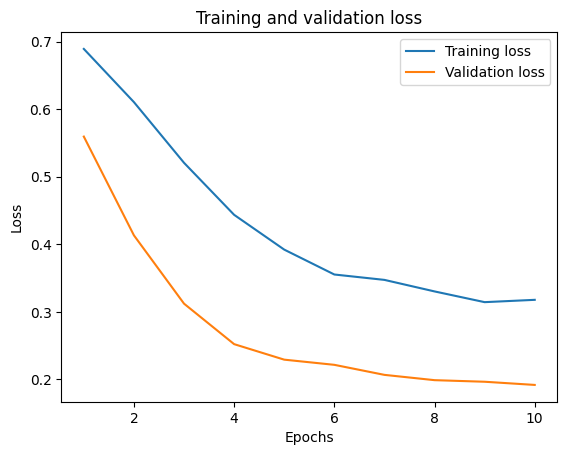

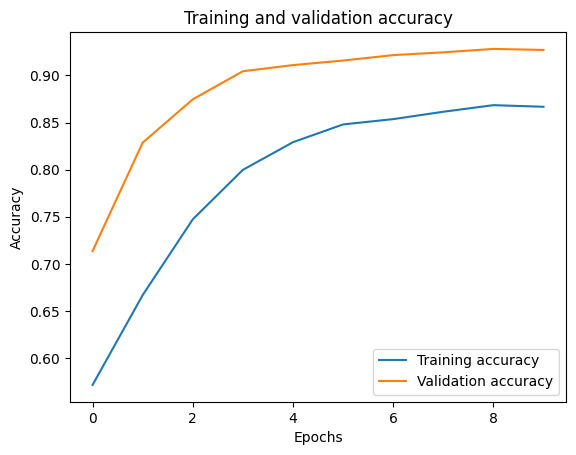

In [ ]:
i = parameters[0]
j = parameters[1]
model=build_lstm(params['n_units'][i], params['lr'][j])

history_LSTM = model.fit(x_train, y_train,
                            epochs = 10,
                            batch_size=128,
                            validation_data=(x_val, y_val),
                            shuffle=True,
                            callbacks = [earlystopping])
epoch = history_LSTM.epoch
plot_loss(history_LSTM)
plot_acc(history_LSTM, epoch)

## Testing: model evaluation and prediction skills

In [ ]:
print("Evaluate model on test data")
model=build_lstm(params['n_units'][i], params['lr'][j])
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

Evaluate model on test data
333/333 [==============================] - 22s 56ms/step - loss: 0.7049 - accuracy: 0.5356
test loss, test acc: [0.7048978209495544, 0.5355801582336426]


In [ ]:
# Generate a prediction using model.predict()
# and calculate it's shape:
print("Generate a prediction")
prediction = model.predict(x_test)
print("prediction shape:", prediction.shape)

Generate a prediction
333/333 [==============================] - 10s 31ms/step
prediction shape: (10652, 1)


In [ ]:
y_pred = []

for i in prediction:
  if i >= 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

print('Accuracy on test set:', accuracy_score(y_pred, y_test))
print('Precision on test set:', precision_score(y_pred, y_test))
print('Recall on test set:', recall_score(y_pred, y_test))

Accuracy on test set: 0.9228313931656027
Precision on test set: 0.8541519642437073
Recall on test set: 0.9472997651969737


In [ ]:
confusion_matrix(y_test, y_pred)

array([[6199,  202],
       [ 620, 3631]])

### Bidirectional LSTM
Bidirectional LSTM (BiLSTM) is a recurrent neural network used primarily on natural language processing. Unlike standard LSTM, the input flows in both directions, and it’s capable of utilizing information from both sides.

In summary, BiLSTM adds one more LSTM layer, which reverses the direction of information flow, meaning that the input sequence flows backward in the additional LSTM layer.

In [ ]:
#BidirectionalLSTM model
def build_bdlstm(n_units, lr):

  model = Sequential()
  #model_LSTM.add(Input(shape=(None,), dtype='int32'))
  model.add(embedding_layer)
  model.add(Bidirectional(LSTM(n_units, return_sequences=True, dropout=0.8, name='lstm_layer')))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     loss='binary_crossentropy',
                     metrics = ['accuracy'])

  return model

In [ ]:
histories = []
min_loss = 0
parameters = {}

for i in range(len(params['n_units'])):
  for j in range(len(params['lr'])):
    model=build_bdlstm(params['n_units'][i], params['lr'][j])

    history = model.fit(x_train, y_train,
                                epochs = 10,
                                batch_size=16,
                                validation_data=(x_val, y_val),
                                shuffle=True,
                                callbacks = [earlystopping],
                                class_weight = class_weights)
    # convert the history.history dict to a pandas DataFrame:
    hist_df = pd.DataFrame(history.history)
    histories.append(hist_df)
    if i==0 and j==0:
      min_loss = hist_df['loss'].min()
      print('First minimum loss:', min_loss)
    else:
      if hist_df['loss'].min() < min_loss:
        min_loss = hist_df['loss'].min()
        parameters[0] = i
        parameters[1] = j
        print('Minimum loss until now:', min_loss, 'parameters:', parameters)


Epoch 1/10
1088/1088 [==============================] - 326s 289ms/step - loss: 7.5741 - accuracy: 0.6654 - val_loss: 5.3221 - val_accuracy: 0.8224
Epoch 2/10
1088/1088 [==============================] - 307s 282ms/step - loss: 9.2211 - accuracy: 0.7160 - val_loss: 5.0000 - val_accuracy: 0.8557
Epoch 3/10
1088/1088 [==============================] - 303s 278ms/step - loss: 9.1312 - accuracy: 0.7398 - val_loss: 5.0000 - val_accuracy: 0.8773
First minimum loss: 7.574073314666748
Epoch 1/10
1088/1088 [==============================] - 317s 283ms/step - loss: 0.6703 - accuracy: 0.7764 - val_loss: 0.4066 - val_accuracy: 0.9189
Epoch 2/10
1088/1088 [==============================] - 300s 275ms/step - loss: 0.6914 - accuracy: 0.8407 - val_loss: 0.4250 - val_accuracy: 0.9292
Minimum loss until now: 0.6702916026115417 parameters: {0: 0, 1: 1}
Epoch 1/10
1088/1088 [==============================] - 334s 297ms/step - loss: 0.4901 - accuracy: 0.7505 - val_loss: 0.2040 - val_accuracy: 0.9281
Epoch 

Epoch 1/10
136/136 [==============================] - 79s 514ms/step - loss: 0.6389 - accuracy: 0.6338 - val_loss: 0.4192 - val_accuracy: 0.8454
Epoch 2/10
136/136 [==============================] - 65s 478ms/step - loss: 0.4403 - accuracy: 0.8108 - val_loss: 0.2556 - val_accuracy: 0.9067
Epoch 3/10
136/136 [==============================] - 69s 512ms/step - loss: 0.3035 - accuracy: 0.8818 - val_loss: 0.2088 - val_accuracy: 0.9276
Epoch 4/10
136/136 [==============================] - 66s 486ms/step - loss: 0.2488 - accuracy: 0.9035 - val_loss: 0.1888 - val_accuracy: 0.9391
Epoch 5/10
136/136 [==============================] - 67s 492ms/step - loss: 0.2242 - accuracy: 0.9133 - val_loss: 0.1793 - val_accuracy: 0.9452
Epoch 6/10
136/136 [==============================] - 72s 528ms/step - loss: 0.2052 - accuracy: 0.9225 - val_loss: 0.1796 - val_accuracy: 0.9466


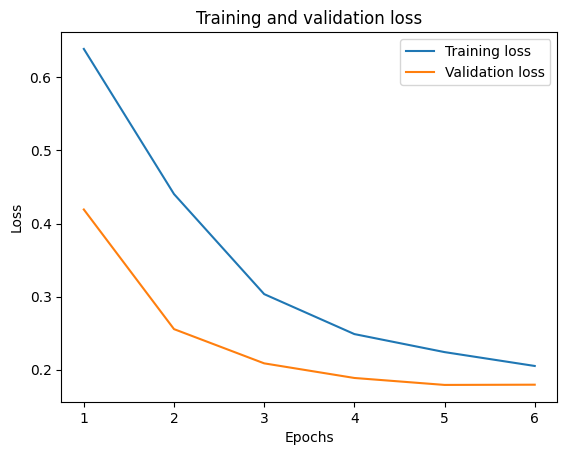

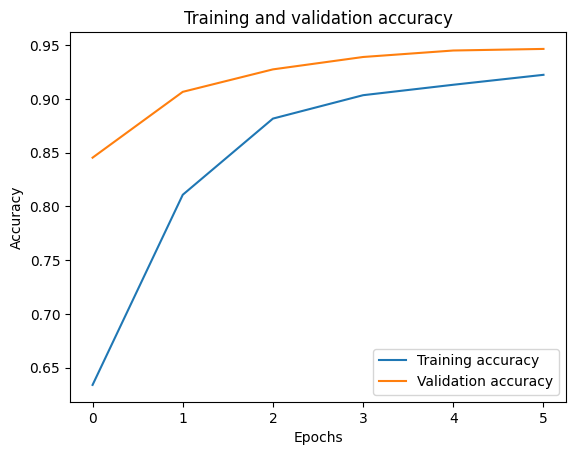

In [ ]:
i = parameters[0]
j = parameters[1]

model=build_bdlstm(params['n_units'][i], params['lr'][j])

history = model.fit(x_train, y_train,
                            epochs = 10,
                            batch_size=128,
                            validation_data=(x_val, y_val),
                            shuffle=True,
                            callbacks = [earlystopping])
epoch = history.epoch
plot_loss(history)
plot_acc(history, epoch)

In [ ]:
print("Evaluate model on test data")
model=build_bdlstm(params['n_units'][i], params['lr'][j])
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

Evaluate model on test data
333/333 [==============================] - 26s 54ms/step - loss: 0.7233 - accuracy: 0.4959
test loss, test acc: [0.7233254313468933, 0.49586930871009827]


In [ ]:
# Generate a prediction using model.predict()
# and calculate its shape:
print("Generate a prediction")
prediction = model.predict(x_test)
print("prediction shape:", prediction.shape)

Generate a prediction
333/333 [==============================] - 20s 51ms/step
prediction shape: (10652, 1)


In [ ]:
y_pred = []

for i in prediction:
  if i >= 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

In [ ]:
#from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

print('Accuracy on test set:', accuracy_score(y_pred, y_test))
print('Precision on test set:', precision_score(y_pred, y_test))
print('Recall on test set:', recall_score(y_pred, y_test))

Accuracy on test set: 0.49586932031543374
Precision on test set: 0.44389555398729713
Recall on test set: 0.38565297363580625


In [ ]:
confusion_matrix(y_pred, y_test)

array([[3395, 2364],
       [3006, 1887]])

# Final considerations

The decision to test LSTM models stems from their peculiar adaptability, due to their ability to store what is considered to be important information. In this project, a Unidirectional LSTM and a Bidirectional LSTM were compared in order to see which one actually was the best fit for a binary text classification task.

The results tell us that this model has a tendency to overfit, as a broader and heavier grid search for hyperparameters is surely needed. Another useful observation could be directred to the data preprocessing, which might also be expanded even though not absolutely necessary: a text vectorization might be a good solution, often useful before applying the word embeddings to the dataset, in order to help the network lighten as much as possible.

Surely, a downside of this otherwise very efficient model (and all its variants) is the time and computational complexity that brings with it and that slow maybe too much all the work.

In the development of this project, the intention was to look at networks that had already been tested and approved for Natural Language processing as a study experiment, but a very interesting future approach could be a shift to extremely elastic models such as Bayesian Networks, which would have on its side its probabilistic nature, excellent for emulating semantic analysis and the relationship between words for classification purposes.


Or again, as suggested in the paper [*Detecting Fake News With Machine Learning*](https://iopscience.iop.org/article/10.1088/1742-6596/1693/1/012158/pdf) (Jeffrey Huang 2020 J. Phys.: Conf. Ser. 1693 012158), a shift to complex networks such as Convolutional Neural Networks, which might be fit for the task considering that, in poor words, a CNN basically joins sets of information. Sliding the filter (or kernel) over the word embeddings to find convolutions might be a practical and good solution, and the fact that these are further dimensionally reduced through the Max Pooling layer reduces complexity and computation and improves drastically the heaviness of LSTM computations, BiLSTM especially.
